In [78]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from finta import TA

In [79]:
ticker = "BTC-USD"

btc_df = yf.download(ticker, period='2y',  index = "Date", interval = "1h")

btc_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2020-11-29 08:00:00,17890.439453,18133.156250,17884.257812,18133.156250,18133.156250,0
2020-11-29 09:00:00,18136.158203,18188.478516,18086.208984,18095.951172,18095.951172,1139404800
2020-11-29 10:00:00,18098.017578,18195.455078,18075.982422,18191.638672,18191.638672,86499328
2020-11-29 11:00:00,18190.937500,18231.302734,18055.810547,18122.757812,18122.757812,0
2020-11-29 12:00:00,18123.544922,18143.638672,17972.767578,18068.222656,18068.222656,190832640


### Add hourly returns column

In [80]:
# Calculate the hourly returns using the closing prices and the pct_change function
btc_df["actual_returns"] = btc_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
btc_df = btc_df.dropna()

# Review the DataFrame
display(btc_df.head())
display(btc_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns
2020-11-29 09:00:00,18136.158203,18188.478516,18086.208984,18095.951172,18095.951172,1139404800,-0.002052
2020-11-29 10:00:00,18098.017578,18195.455078,18075.982422,18191.638672,18191.638672,86499328,0.005288
2020-11-29 11:00:00,18190.937500,18231.302734,18055.810547,18122.757812,18122.757812,0,-0.003786
2020-11-29 12:00:00,18123.544922,18143.638672,17972.767578,18068.222656,18068.222656,190832640,-0.003009
2020-11-29 13:00:00,18067.707031,18117.455078,18045.640625,18071.957031,18071.957031,203304960,0.000207


,Open,High,Low,Close,Adj Close,Volume,actual_returns
2022-11-29 05:00:00,16437.890625,16504.250000,16432.775391,16476.644531,16476.644531,469626880,0.002276
2022-11-29 06:00:00,16475.802734,16490.964844,16459.437500,16463.218750,16463.218750,54661120,-0.000815
2022-11-29 07:00:00,16463.595703,16492.570312,16463.433594,16465.919922,16465.919922,314869760,0.000164
2022-11-29 08:00:00,16466.505859,16472.082031,16441.384766,16443.371094,16443.371094,225576960,-0.001369
2022-11-29 08:19:00,16442.363281,16442.363281,16442.363281,16442.363281,16442.363281,0,-0.000061


### Generating the Features and Target Sets

In [81]:
# Generate 3EMA with windows 50, 100, 200

short_window = 5
middle_window = 8
long_window = 13

# Create a short window EMA
btc_df["EMA5"] = btc_df["Close"].ewm(span=short_window).mean()

# Create a middle window EMA
btc_df["EMA8"] = btc_df["Close"].ewm(span=middle_window).mean()

# Create a short window EMA
btc_df["EMA13"] = btc_df["Close"].ewm(span=long_window).mean()

D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [82]:
# Generate RSI
btc_rsi = TA.RSI(btc_df)  

# Join RSI with the original dataframe.
btc_df = pd.concat([btc_df, btc_rsi], axis = 1)

In [83]:
# Generate Bolinger Bands
btc_bbands_df = TA.BBANDS(btc_df)

# Concatenate the Bollinger Bands to the DataFrame
btc_df = pd.concat([btc_df,btc_bbands_df], axis=1)

In [84]:
# Drop nulls & review new df
btc_df = btc_df.dropna()

btc_df.head()

,Open,High,Low,Close,Adj Close,Volume,actual_returns,EMA5,EMA8,EMA13,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2020-11-30 04:00:00,18527.080078,18565.929688,18447.783203,18457.994141,18457.994141,194490368,-0.003598,18423.689272,18372.312482,18317.150264,68.082357,18512.975134,18203.606738,17894.238343
2020-11-30 05:00:00,18458.519531,18545.699219,18446.550781,18472.421875,18472.421875,0,0.000782,18439.936730,18394.673157,18340.238724,68.772207,18549.523425,18222.430273,17895.337122
2020-11-30 06:00:00,18473.146484,18489.650391,18444.550781,18464.953125,18464.953125,0,-0.000404,18448.276643,18410.353182,18358.675738,67.953423,18580.169531,18236.095996,17892.022461
2020-11-30 07:00:00,18464.787109,18609.609375,18464.787109,18580.474609,18580.474609,3268120576,0.006256,18492.346559,18448.275046,18391.302749,73.256972,18631.063375,18258.981836,17886.900297
2020-11-30 08:00:00,18580.697266,18580.697266,18425.009766,18454.947266,18454.947266,0,-0.006756,18479.879387,18449.761332,18400.625400,61.371602,18648.850480,18278.318066,17907.785653


### Create target set

In [85]:
btc_signals_df = pd.DataFrame()
btc_signals_df["Close"] = btc_df["Close"]

In [86]:
# Create a trading algorithm using Bollinger Bands
# Set the Signal column
btc_signals_df["Signal"] = 0.0

# Generate the trading signals 1 (entry) or -1 (exit) for a long position trading algorithm
# where 1 is when the Close price is less than the EMA 200 and under 25 for RSI.
# where -1 is when the Close price is greater than 80 RSI.
for index, row in btc_df.iterrows():
    if row["14 period RSI"] <= 25:
        btc_signals_df.loc[index, "Signal"] = 1.0
    if row["14 period RSI"] >= 80:
        btc_signals_df.loc[index,"Signal"] = -1.0

btc_signals_df["Signal"] = btc_signals_df["Signal"]
btc_signals_df["Entry/Exit"] = btc_signals_df["Signal"].diff()        
        
# Review the DataFrame
btc_signals_df

,Close,Signal,Entry/Exit
2020-11-30 04:00:00,18457.994141,0.0,NaN
2020-11-30 05:00:00,18472.421875,0.0,0.0
2020-11-30 06:00:00,18464.953125,0.0,0.0
2020-11-30 07:00:00,18580.474609,0.0,0.0
2020-11-30 08:00:00,18454.947266,0.0,0.0
...,...,...,...
2022-11-29 05:00:00,16476.644531,0.0,0.0
2022-11-29 06:00:00,16463.218750,0.0,0.0
2022-11-29 07:00:00,16465.919922,0.0,0.0
2022-11-29 08:00:00,16443.371094,0.0,0.0


In [87]:
# Visualize entry position relative to close price
entry = btc_signals_df[btc_signals_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = btc_signals_df[btc_signals_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
btc_close = btc_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema13 = btc_df[["EMA13"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema8 = btc_df[["EMA8"]].hvplot(
    line_color='yellow',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema5 = btc_df[["EMA5"]].hvplot(
    line_color='red',
    ylabel='Price in $',
    width=1000,
    height=400
)


RSI = btc_df[["14 period RSI"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)



# Overlay plots
plot = btc_close * ema5 * ema8 * ema13 * RSI * entry * exit
plot



:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Curve.II         :Curve   [index]   (EMA5)
   .Curve.III        :Curve   [index]   (EMA8)
   .Curve.IV         :Curve   [index]   (EMA13)
   .Curve.V          :Curve   [index]   (14 period RSI)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

## Create portfolio

In [88]:
# Set initial capital
initial_capital = float(100000)

# Set the coin size
position_size = 1

In [89]:
# Buy a 1 coin position when the RSI is <= 25
# Otherwise, `Position` should be zero (sell)
btc_signals_df['Position'] = position_size * btc_signals_df['Signal']

In [90]:
# Determine the points in time where a 1 coin position is bought or sold
btc_signals_df['Entry/Exit Position'] = btc_signals_df['Position'].diff()

In [91]:
# Multiply the close price by the number of coins held
btc_signals_df['Portfolio Holdings'] = btc_signals_df['Close'] * btc_signals_df['Position']

In [92]:
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
btc_signals_df['Portfolio Cash'] = initial_capital - (btc_signals_df['Close'] * btc_signals_df['Entry/Exit Position']).cumsum() 

In [93]:
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
btc_signals_df['Portfolio Total'] = btc_signals_df['Portfolio Cash'] + btc_signals_df['Portfolio Holdings']

In [94]:
# Calculate the portfolio daily returns
btc_signals_df['Portfolio Daily Returns'] = btc_signals_df['Portfolio Total'].pct_change()

In [95]:
# Calculate the portfolio cumulative returns
btc_signals_df['Portfolio Cumulative Returns'] = (1 + btc_signals_df['Portfolio Daily Returns']).cumprod() - 1

In [96]:
# Print the DataFrame
display(btc_signals_df.head())
display(btc_signals_df.tail())

,Close,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2020-11-30 04:00:00,18457.994141,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-11-30 05:00:00,18472.421875,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2020-11-30 06:00:00,18464.953125,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-11-30 07:00:00,18580.474609,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-11-30 08:00:00,18454.947266,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0


,Close,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2022-11-29 05:00:00,16476.644531,0.0,0.0,0.0,0.0,0.0,109880.381836,109880.381836,0.0,0.098804
2022-11-29 06:00:00,16463.218750,0.0,0.0,0.0,0.0,0.0,109880.381836,109880.381836,0.0,0.098804
2022-11-29 07:00:00,16465.919922,0.0,0.0,0.0,0.0,0.0,109880.381836,109880.381836,0.0,0.098804
2022-11-29 08:00:00,16443.371094,0.0,0.0,0.0,0.0,0.0,109880.381836,109880.381836,0.0,0.098804
2022-11-29 08:19:00,16442.363281,0.0,0.0,0.0,0.0,0.0,109880.381836,109880.381836,0.0,0.098804


In [97]:
# Visualize exit position relative to total portfolio value
exit = btc_signals_df[btc_signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = btc_signals_df[btc_signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = btc_signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="BTC Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [index]   (Portfolio Total)

In [98]:
ending_portfolio_value = btc_signals_df["Portfolio Total"].iloc[-1]
total_return_dollar = round(ending_portfolio_value - initial_capital, 2)
total_return_percent = round((total_return_dollar/initial_capital)*100,2)
buy_hold_value = (initial_capital/btc_signals_df["Close"].iloc[1] * btc_signals_df["Close"].iloc[-1])

In [99]:
print(f"Starting with a ${initial_capital} investment and using a {position_size} coin position size, the overall return of this algorithm is ${total_return_dollar} or {total_return_percent}%.")
print(f"In comparison, buying and holding ${initial_capital} worth of BTC over the same time period would end up with a return of ${round(buy_hold_value - initial_capital,2)} or {round((buy_hold_value - initial_capital)/initial_capital*100,2)}%.")

Starting with a $100000.0 investment and using a 1 coin position size, the overall return of this algorithm is $9880.38 or 9.88%.
In comparison, buying and holding $100000.0 worth of BTC over the same time period would end up with a return of $-10989.67 or -10.99%.


### Add more indicators for feature set

In [166]:
btc_ao = TA.AO(btc_df)
btc_vortex = TA.VORTEX(btc_df)
btc_roc = TA.ROC(btc_df)
btc_mom = TA.MOM(btc_df)
btc_fib = TA.PIVOT_FIB(btc_df)
btc_chaikin = TA.CHAIKIN(btc_df)
btc_obv = TA.OBV(btc_df)
btc_ichi = TA.ICHIMOKU(btc_df)

### Create feature set

In [187]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = pd.concat([btc_bbands_df, btc_rsi, btc_ao, btc_vortex, btc_roc, btc_mom, btc_fib, btc_chaikin, btc_obv], axis = 1)

X = X.dropna()

# Display sample data
display(X.head())

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2020-12-01 13:00:00,19899.587578,19396.670508,18893.753437,39.907706,127.125195,1.249839,0.675751,-3.928613,-681.195312,18969.013021,18692.982954,18522.451290,18246.421224,17970.391158,19245.043087,19415.574751,19691.604818,19967.634884,-3.946434e+08,6.663995e+09
2020-12-01 14:00:00,19898.023280,19399.912988,18901.802697,51.021244,15.980021,1.091209,0.800936,-2.069754,-163.884766,18650.508464,18456.569600,18336.753967,18142.815104,17948.876241,18844.447327,18964.262960,19158.201823,19352.140686,-2.524025e+08,6.663995e+09
2020-12-01 15:00:00,19895.909587,19404.835059,18913.760530,51.639817,-74.325850,1.038950,0.943842,-1.013789,-187.738281,19089.585286,18869.366017,18733.314322,18513.095052,18292.875783,19309.804556,19445.856251,19666.075521,19886.294790,-1.712627e+08,6.663995e+09
2020-12-01 16:00:00,19902.494261,19387.821289,18873.148317,46.776150,-181.573627,1.086820,0.859603,-1.842819,-269.580078,19318.636068,19243.723779,19197.442888,19122.530599,19047.618310,19393.548357,19439.829247,19514.741536,19589.653826,-1.224966e+08,6.663995e+09
2020-12-01 17:00:00,19909.067409,19372.833301,18836.599192,46.572648,-225.685926,1.139417,0.824023,-2.159585,-437.027344,19113.449219,18989.449930,18912.843039,18788.843750,18664.844461,19237.448508,19314.055398,19438.054688,19562.053977,-6.720036e+07,6.580400e+09


### Split the Data Into Training and Testing Datasets

In [188]:
# Copy the new signal column to a new Series called y.
y = btc_signals_df["Signal"].copy()

In [189]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-12-01 13:00:00


In [190]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2021-03-01 13:00:00


In [191]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2020-12-01 13:00:00,19899.587578,19396.670508,18893.753437,39.907706,127.125195,1.249839,0.675751,-3.928613,-681.195312,18969.013021,18692.982954,18522.451290,18246.421224,17970.391158,19245.043087,19415.574751,19691.604818,19967.634884,-3.946434e+08,6.663995e+09
2020-12-01 14:00:00,19898.023280,19399.912988,18901.802697,51.021244,15.980021,1.091209,0.800936,-2.069754,-163.884766,18650.508464,18456.569600,18336.753967,18142.815104,17948.876241,18844.447327,18964.262960,19158.201823,19352.140686,-2.524025e+08,6.663995e+09
2020-12-01 15:00:00,19895.909587,19404.835059,18913.760530,51.639817,-74.325850,1.038950,0.943842,-1.013789,-187.738281,19089.585286,18869.366017,18733.314322,18513.095052,18292.875783,19309.804556,19445.856251,19666.075521,19886.294790,-1.712627e+08,6.663995e+09
2020-12-01 16:00:00,19902.494261,19387.821289,18873.148317,46.776150,-181.573627,1.086820,0.859603,-1.842819,-269.580078,19318.636068,19243.723779,19197.442888,19122.530599,19047.618310,19393.548357,19439.829247,19514.741536,19589.653826,-1.224966e+08,6.663995e+09
2020-12-01 17:00:00,19909.067409,19372.833301,18836.599192,46.572648,-225.685926,1.139417,0.824023,-2.159585,-437.027344,19113.449219,18989.449930,18912.843039,18788.843750,18664.844461,19237.448508,19314.055398,19438.054688,19562.053977,-6.720036e+07,6.580400e+09


In [192]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2021-03-01 13:00:00,48619.034553,46266.681445,43914.328338,70.540570,2089.410719,0.672145,1.391368,3.829447,1529.980469,47797.109375,47636.884250,47537.897000,47377.671875,47217.446750,47957.334500,48056.321750,48216.546875,48376.772000,1.021896e+12,2.508943e+14
2021-03-01 14:00:00,48672.203085,46486.643750,44301.084415,71.720801,2160.364453,0.705843,1.406708,3.387130,1645.281250,48054.682292,47916.590784,47831.277706,47693.186198,47555.094690,48192.773799,48278.086878,48416.178385,48554.269893,8.663450e+11,2.508943e+14
2021-03-01 15:00:00,49002.679964,46716.915039,44431.150114,77.434407,2305.590234,0.613254,1.299235,5.729793,2871.332031,48099.451823,47845.542690,47688.677362,47434.768229,47180.859096,48353.360956,48510.226284,48764.135417,49018.044549,7.246082e+11,2.508964e+14
2021-03-01 16:00:00,49295.020859,46931.541992,44568.063125,77.609848,2440.884547,0.644792,1.353888,5.691934,3230.742188,48817.152344,48435.414969,48199.577219,47817.839844,47436.102469,49198.889719,49434.727469,49816.464844,50198.202219,6.007561e+11,2.508964e+14
2021-03-01 17:00:00,49457.541063,47100.459961,44743.378859,69.489712,2549.828114,0.647844,1.310279,5.230242,2325.687500,49068.944010,48837.871315,48695.114362,48464.041667,48232.968971,49300.016706,49442.773659,49673.846354,49904.919049,4.954706e+11,2.508964e+14


### Standardizing the Data

In [207]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [208]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [209]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.85      0.64      0.73        53
         0.0       0.98      1.00      0.99      2089
         1.0       0.00      0.00      0.00        18

    accuracy                           0.98      2160
   macro avg       0.61      0.55      0.57      2160
weighted avg       0.97      0.98      0.98      2160



D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Backtesting a Machine Learning Trading Algorithm

In [210]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [197]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.40      0.33      0.36       129
         0.0       0.97      1.00      0.98     14553
         1.0       0.00      0.00      0.00       403

    accuracy                           0.96     15085
   macro avg       0.46      0.44      0.45     15085
weighted avg       0.94      0.96      0.95     15085



D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = btc_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-03-01 13:00:00,0.0,0.001984,0.0
2021-03-01 14:00:00,0.0,0.003436,0.0
2021-03-01 15:00:00,0.0,0.020094,0.0
2021-03-01 16:00:00,0.0,0.000709,0.0
2021-03-01 17:00:00,0.0,-0.009893,-0.0


<AxesSubplot:title={'center':'SVM Trading Algorithm'}>

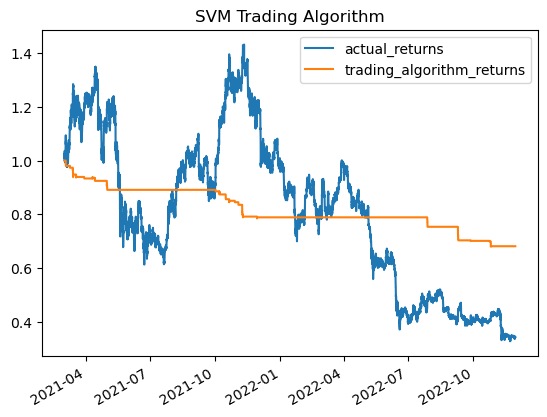

In [199]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "SVM Trading Algorithm")

### Add a Logistic Regression Model

In [200]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [201]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [202]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [203]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.98      0.94      0.96        53
         0.0       0.99      1.00      1.00      2089
         1.0       1.00      0.50      0.67        18

    accuracy                           0.99      2160
   macro avg       0.99      0.81      0.88      2160
weighted avg       0.99      0.99      0.99      2160



In [204]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [205]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      0.46      0.63       129
         0.0       0.98      1.00      0.99     14553
         1.0       0.91      0.46      0.61       403

    accuracy                           0.98     15085
   macro avg       0.96      0.64      0.74     15085
weighted avg       0.98      0.98      0.98     15085



In [206]:
# Create a new empty predictions DataFrame using code provided below.
lr_predictions_df = pd.DataFrame(index=X_test.index)
lr_predictions_df["predicted_signal"] = lr_testing_signal_predictions
lr_predictions_df["actual_returns"] = btc_df["actual_returns"]
lr_predictions_df["trading_algorithm_returns"] = lr_predictions_df["actual_returns"] * lr_predictions_df["predicted_signal"]
lr_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-03-01 13:00:00,0.0,0.001984,0.0
2021-03-01 14:00:00,0.0,0.003436,0.0
2021-03-01 15:00:00,0.0,0.020094,0.0
2021-03-01 16:00:00,0.0,0.000709,0.0
2021-03-01 17:00:00,0.0,-0.009893,-0.0


<AxesSubplot:title={'center':'Logistic Regression Trading Algorithm'}>

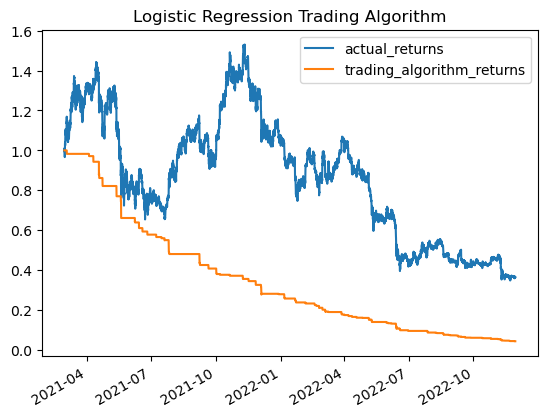

In [135]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "Logistic Regression Trading Algorithm")

## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [ ]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

In [ ]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)